In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from tqdm import tqdm

# Define MAPE function
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

# Load the dataset
df = pd.read_csv('Train.csv')

# Convert the 'date_time' column to datetime and sort the dataset
df['date_time'] = pd.to_datetime(df['date_time'])
df.sort_values('date_time', inplace=True)
df.set_index('date_time', inplace=True)

# One-hot encode categorical features
df = pd.get_dummies(df, columns=['is_holiday', 'weather_type', 'weather_description'], drop_first=True)

# Feature engineering: create lagged and rolling features
features = ['temperature', 'rain_1h', 'snow_1h', 'clouds_all', 'hour']
target = 'traffic_volume'
for i in range(1, 4):
    df[f'traffic_volume_lag_{i}'] = df[target].shift(i)
df['traffic_volume_rolling_mean'] = df[target].rolling(window=3).mean().shift(1)
df['traffic_volume_rolling_std'] = df[target].rolling(window=3).std().shift(1)

# Remove rows with NaN values resulting from lagged features
df.dropna(inplace=True)

# Split the dataset into features and the target
X = df.drop(target, axis=1)
y = df[target]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the scaled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# Initialize and train the XGBoost model with a progress bar
xgboost_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1
)

# Using tqdm to show a progress bar
for i in tqdm(range(100)):  # Assuming 100 iterations as an example
    xgboost_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

# Predict on the test set
y_pred = xgboost_model.predict(X_test)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

traffic_volume_range = df[target].max() - df[target].min()

# Normalize RMSE and MAE
normalized_rmse = rmse / traffic_volume_range
normalized_mae = mae / traffic_volume_range

# Output the metrics
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Normalized Root Mean Squared Error (RMSE): {normalized_rmse}")
print(f"Normalized Mean Absolute Error (MAE): {normalized_mae}")
print(f"R-squared (R2): {r2}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

# Save the model for later use
xgboost_model.save_model('xgboost_model.json')


100%|██████████| 100/100 [00:39<00:00,  2.53it/s]

Root Mean Squared Error (RMSE): 490.66510237373586
Mean Absolute Error (MAE): 328.67989586950233
Normalized Root Mean Squared Error (RMSE): 0.06739905252386481
Normalized Mean Absolute Error (MAE): 0.04514833734471186
R-squared (R2): 0.9369722404437997
Mean Absolute Percentage Error (MAPE): 18.19072145441493%


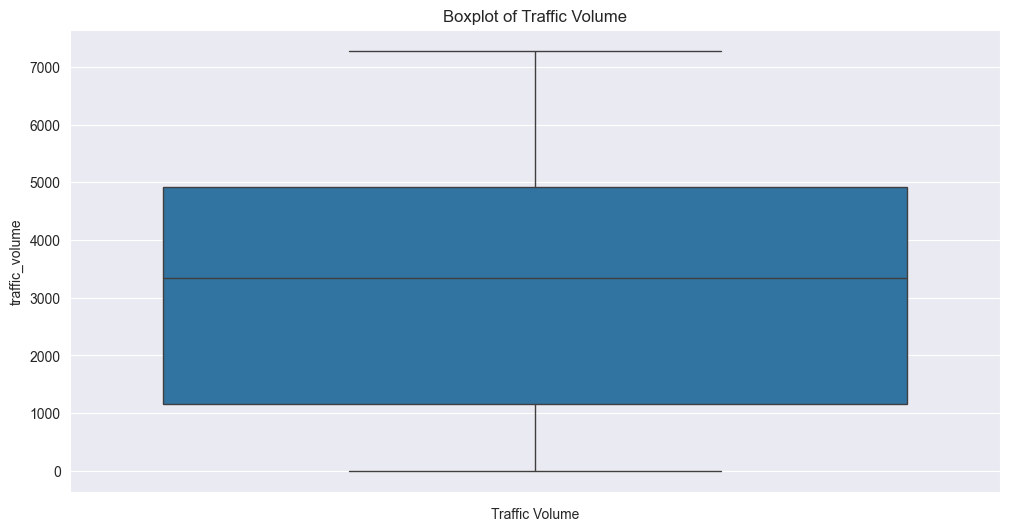

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and 'traffic_volume' is the column you want to inspect
plt.figure(figsize=(12, 6))
sns.boxplot(df['traffic_volume'])
plt.title('Boxplot of Traffic Volume')
plt.xlabel('Traffic Volume')
plt.show()
